# (Optional) Load Data from Kaggle into Google Colab

In [7]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'aiim-emotion-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F77823%2F8553100%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240703%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240703T090247Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc04465bd270ce3e228ee471434371bbe80f78ee95e4d36bc797b023cc9bd54dde4b4ed5cf70b099d594725687f5161c9ba30ac9d9e5f005006104d4fa5881496161efb4697ea71317dd09a4b080c9be1733f01e0ef939b3d8264ec01c3f10ea8999ad55f9e473f30ab29604f89bc687359af4c7a9afed58f827bc31344080727ced469d996f236ac2de34e7cae4b67aed0c71db1935e4af7aeb94f1354fa61fbb9c3ca3816e641ab865a5cb779734a5cc1ab5db66c4c8562f04d34106e418f32dfa87936318e7c70074b54015986197a396ca1bf68baa6574e31cc2e231e2a3db4d1db4f2012aca4cd86d7360c8f870f1b70b3dc6ee0b6c219cbfe8fc48bb81f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 18175099 bytes downloaded
Downloaded and uncompressed: aiim-emotion-classification
Data source import complete.


### Imports

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
from keras.utils import image_dataset_from_directory, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D,  Flatten, Dense, Dropout, BatchNormalization, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness, Rescaling, RandomTranslation, GlobalMaxPooling2D
from keras.optimizers import Adam, SGD
from keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.losses import CategoricalCrossentropy
from sklearn.metrics import f1_score, confusion_matrix, classification_report

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


# Fine-tuning Models

In [ ]:
!pip install keras_cv

In [9]:
import keras_cv
from keras.layers import GlobalAveragePooling2D
from keras_cv.layers import RandAugment, RandomCutout, RandomChoice
from keras.applications import ResNet50, ResNet50V2, Xception, EfficientNetB0, EfficientNetB4, ConvNeXtXLarge, ConvNeXtLarge
from sklearn.utils import class_weight

base_directory = '/kaggle/input/aiim-emotion-classification/aiim-emotion-classification/'
batch_size = 64
epochs = 70

# Documentation: https://keras.io/api/data_loading/image/
train_ds, validation_ds = image_dataset_from_directory(
    directory=base_directory + 'train/',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    shuffle=True,
    seed=420,
    subset="both",
    validation_split=0.15,
    image_size=(100, 100),
    interpolation='bilinear')


class_names = train_ds.class_names

train_labels = np.concatenate([y.numpy() for x, y in train_ds], axis=0)
train_labels = np.argmax(train_labels, axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

mix_up = keras_cv.layers.MixUp()

cut_mix = keras_cv.layers.CutMix()

layers = keras_cv.layers.RandAugment.get_standard_policy(
    value_range=(0, 255), magnitude=0.4, magnitude_stddev=0.2,
)

layers = [
    layer for layer in layers if not isinstance(layer, keras_cv.layers.RandomColorDegeneration)
]

augmenters = [
    RandomFlip("horizontal"),
    keras_cv.layers.RandomAugmentationPipeline(
    layers=layers, augmentations_per_image=3
),
    RandomCutout(width_factor=0.2, height_factor=0.2),
    RandomChoice([cut_mix, mix_up], batchwise=True),
]

# Since the images are grayscale, we need to convert them to RGB by repeating the grayscale channel
def to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

train_ds_rgb = train_ds.map(to_rgb)
validation_ds_rgb = validation_ds.map(to_rgb)

def create_augmenter_fn(augmenters):
    def augmenter_fn(image, label):
        inputs = {"images": image, "labels": label}
        for augmenter in augmenters:
            if isinstance(augmenter, (RandomFlip, RandomRotation)):
                inputs["images"] = augmenter(inputs["images"])
            else:
                inputs = augmenter(inputs)
        return inputs["images"], inputs["labels"]
    return augmenter_fn

augmenter_fn = create_augmenter_fn(augmenters)
train_ds_preprocessed = train_ds_rgb.map(augmenter_fn)
validation_ds_preprocessed = validation_ds_rgb

Found 9108 files belonging to 5 classes.
Using 7742 files for training.
Using 1366 files for validation.
{0: 0.8991869918699187, 1: 1.6419936373276776, 2: 0.9081524926686217, 3: 0.9211183819155264, 4: 0.9156712004730928}


In [10]:
# Create the ResNet model
base_model = ConvNeXtLarge(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
model.summary()

785596384/785596384 [==============================] - 8s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_large (Functional  (None, 3, 3, 1536)        196230336 
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 5)                 7685      
                                                                 
Total params: 196238021 (748.59 MB)
Trainable params: 196238021 (748.59 MB)
Non-trainable params: 0 (0.00 Byte)
_________

In [11]:
base_model.trainable = False

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.00001)

history = model.fit(
    train_ds_preprocessed,
    validation_data=validation_ds_preprocessed,
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/70
121/121 [==============================] - 75s 435ms/step - loss: 1.7219 - accuracy: 0.3435 - val_loss: 0.9542 - val_accuracy: 0.6340 - lr: 0.0010
Epoch 2/70
121/121 [==============================] - 41s 336ms/step - loss: 1.5144 - accuracy: 0.4171 - val_loss: 0.9004 - val_accuracy: 0.6633 - lr: 0.0010
Epoch 3/70
121/121 [==============================] - 41s 337ms/step - loss: 1.4656 - accuracy: 0.4318 - val_loss: 0.8742 - val_accuracy: 0.6779 - lr: 0.0010
Epoch 4/70
121/121 [==============================] - 41s 335ms/step - loss: 1.4346 - accuracy: 0.4367 - val_loss: 0.8777 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 5/70
121/121 [==============================] - 41s 337ms/step - loss: 1.3786 - accuracy: 0.4707 - val_loss: 0.8534 - val_accuracy: 0.6859 - lr: 0.0010
Epoch 6/70
121/121 [==============================] - 42s 344ms/step - loss: 1.3732 - accuracy: 0.4700 - val_loss: 0.8611 - val_accuracy: 0.6859 - lr: 0.0010
Epoch 7/70
121/121 [==============================] 

In [12]:
# Unfreeze the base model
base_model.trainable = True
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False

model.compile(optimizer=Adam(1e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=9)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=1e-7)

history_finetune = model.fit(
    train_ds_preprocessed,
    validation_data=validation_ds_preprocessed,
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/70
121/121 [==============================] - 162s 808ms/step - loss: 1.2901 - accuracy: 0.5076 - val_loss: 0.6880 - val_accuracy: 0.7438 - lr: 1.0000e-04
Epoch 2/70
121/121 [==============================] - 90s 747ms/step - loss: 1.2061 - accuracy: 0.5542 - val_loss: 0.6610 - val_accuracy: 0.7533 - lr: 1.0000e-04
Epoch 3/70
121/121 [==============================] - 91s 750ms/step - loss: 1.1052 - accuracy: 0.6086 - val_loss: 0.5461 - val_accuracy: 0.8001 - lr: 1.0000e-04
Epoch 4/70
121/121 [==============================] - 92s 759ms/step - loss: 1.1071 - accuracy: 0.6137 - val_loss: 0.5398 - val_accuracy: 0.8148 - lr: 1.0000e-04
Epoch 5/70
121/121 [==============================] - 91s 754ms/step - loss: 1.0185 - accuracy: 0.6633 - val_loss: 0.4853 - val_accuracy: 0.8331 - lr: 1.0000e-04
Epoch 6/70
121/121 [==============================] - 92s 760ms/step - loss: 0.9997 - accuracy: 0.6757 - val_loss: 0.4681 - val_accuracy: 0.8316 - lr: 1.0000e-04
Epoch 7/70
121/121 [=======

In [13]:
y_val_true = np.concatenate([y for x, y in validation_ds_preprocessed], axis=0)
y_val_pred = model.predict(validation_ds_preprocessed)

y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val_true, axis=1)

f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')
print("F1-Score: ", f1)

22/22 [==============================] - 7s 164ms/step
F1-Score:  0.8685606463859221


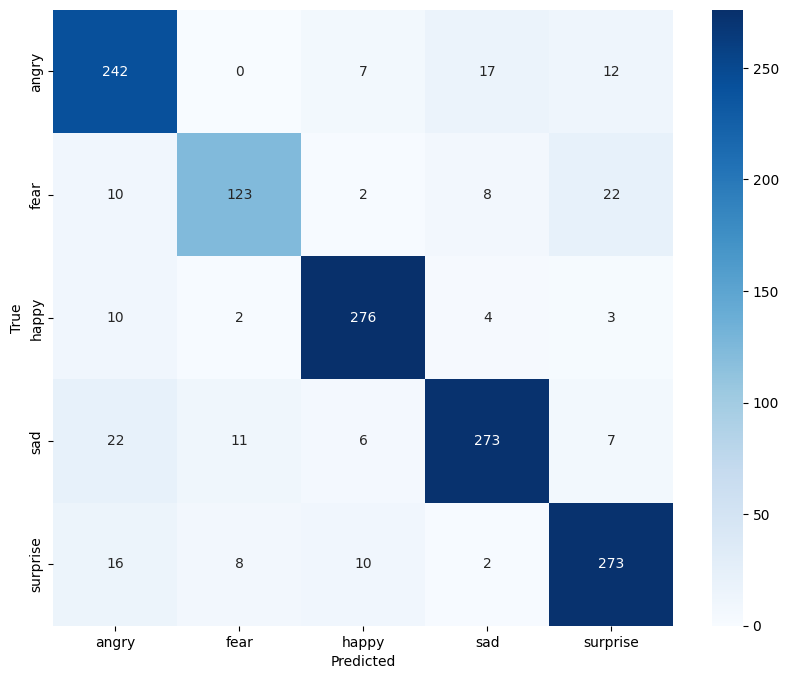

              precision    recall  f1-score   support

       angry       0.81      0.87      0.84       278
        fear       0.85      0.75      0.80       165
       happy       0.92      0.94      0.93       295
         sad       0.90      0.86      0.88       319
    surprise       0.86      0.88      0.87       309

    accuracy                           0.87      1366
   macro avg       0.87      0.86      0.86      1366
weighted avg       0.87      0.87      0.87      1366



In [14]:
# Confusion Matrix und Classification Report
cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=class_names))


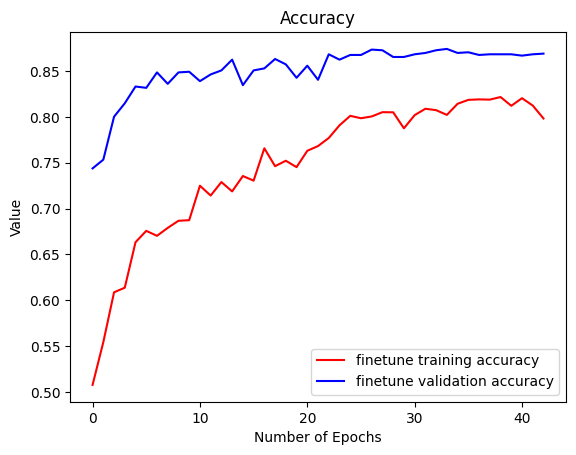

In [15]:
# Plot the loss and accuracy curves for training and validation
plt.plot(history_finetune.history['accuracy'], color='r', label="finetune training accuracy")
plt.plot(history_finetune.history['val_accuracy'], color='b', label="finetune validation accuracy")
plt.title("Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

# Create Submission

In [16]:
file_names = []
images = []
test_directory = base_directory + 'test/'

for filename in os.listdir(test_directory):
    if filename.endswith(".jpg"):
        img_path = os.path.join(test_directory, filename)
        img = load_img(img_path, target_size=(100, 100), color_mode='grayscale', interpolation='bilinear')

        img = tf.convert_to_tensor(img, dtype=tf.float32)

        img = tf.expand_dims(img, axis=-1)

        img_array = tf.image.grayscale_to_rgb(img)

        images.append(img_array)
        file_names.append(filename)

images_array = np.array(images)


y_test = model.predict(images_array)
y_pred_indices = np.argmax(y_test, axis=1)
y_pred_labels = [class_names[idx] for idx in y_pred_indices]

df = pd.DataFrame({
    'Id': file_names,
    'emotions': y_pred_labels
})

df.to_csv('./submission.csv', index=False)

75/75 [==============================] - 16s 129ms/step
